# SparkSQL y Spark DataFrames

`SparkSQL` nos permitirá integrar nuestras fuentes manejando JSON y PSV para generar la capa cruda de datos.

Como siempre, empezamos obtniendo el `SparkContext`

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [2]:
sqlContext = pyspark.SQLContext(sc)

In [3]:
from pyspark.sql import Row
import pandas as pd
pd.set_option('display.mpl_style', 'default')

## Validamos Tweepy.Stream

Ahora leeremos el archivo de transacciones creado por Tweepy

In [4]:
! wc -l EARaw.json

159 EARaw.json


**NOTA**: Si marca error la última instrucción, regresa al laboratorio anterior y crea de nuevo el archivo.

## DataFrame desde JSON (Stage 1)

Creamos **Stage #1** generamos la primera generación de datos pasando de JSON a SQLContext

In [5]:
EgyptAirJsons = sqlContext.read.json("EARaw.json")
EgyptAirJsons.registerTempTable("EgyptAirJsons")
pd_tbl_EARaw = sqlContext.sql('select id,text, created_at, user.time_zone from EgyptAirJsons ').toPandas()


In [6]:
pd_tbl_EARaw.head()

,id,text,created_at,time_zone
0,735673785936973826,RT @Shahram_Tavasol: EgyptAir to contract Fren...,Thu May 26 03:27:53 +0000 2016,None
1,735673874319298560,Avión del #vuelo804 de @EGYPTAIR no presentaba...,Thu May 26 03:28:14 +0000 2016,Eastern Time (US & Canada)
2,735674004627947520,#IndonesiaHealth Memilah Fakta dan Dugaan di B...,Thu May 26 03:28:45 +0000 2016,Jakarta
3,735674024848723968,Perusahaan Perancis dan Italia Bantu Pencarian...,Thu May 26 03:28:50 +0000 2016,Jakarta
4,735674069291520000,RT @ElNacionalWeb: Difundieron audio del vuelo...,Thu May 26 03:29:00 +0000 2016,None


## RDD desde PSV (Stage 2)

Creamos **Stage #2** generamos la segunda extracción de datos pasando de RDD a SQLContext, esto para lograr la consolidación del resto de la inforamación.

In [7]:
def getTransaccion(linea):
    cells = linea.split('|')
    cells[2] = str(cells[2])
    return Transaccion(*cells)

Creamos **Stage #2** generamos la segunda extracción de datos pasando de RDD a SQLContext, esto para lograr la consolidación del resto de la inforamación.

In [8]:
txs_rdd = sc.textFile("EASentiment.psv")
Transaccion = Row('id', 'sentiment', 'polarity')
txs = txs_rdd.map(getTransaccion)
txs_df = txs.toDF()
txs_df.registerTempTable('EASentiment')
pd_tbl_EASentiment = sqlContext.sql('select id, sentiment, polarity from EASentiment ').toPandas()

In [9]:
pd_tbl_EASentiment.head()

,id,sentiment,polarity
0,735673785936973826,negativo,-0.05555555555555555
1,735673874319298560,neutral,0.0
2,735674004627947520,neutral,0.0
3,735674024848723968,neutral,0.0
4,735674069291520000,neutral,0.0


## DF y SQLContext (Stage 3)

Se integra la información para tener los datos **consolidados**

In [10]:
pd_jnr_Consolidado = sqlContext.sql('SELECT EASentiment.id, EASentiment.sentiment, EASentiment.polarity, EgyptAirJsons.text, EgyptAirJsons.created_at, EgyptAirJsons.user.time_zone '\
                                    'FROM EASentiment, EgyptAirJsons ' \
                                    'WHERE EASentiment.id = EgyptAirJsons.id').toPandas()

In [11]:
pd_jnr_Consolidado.head()

,id,sentiment,polarity,text,created_at,time_zone
0,735673785936973826,negativo,-0.05555555555555555,RT @Shahram_Tavasol: EgyptAir to contract Fren...,Thu May 26 03:27:53 +0000 2016,None
1,735673874319298560,neutral,0.0,Avión del #vuelo804 de @EGYPTAIR no presentaba...,Thu May 26 03:28:14 +0000 2016,Eastern Time (US & Canada)
2,735674004627947520,neutral,0.0,#IndonesiaHealth Memilah Fakta dan Dugaan di B...,Thu May 26 03:28:45 +0000 2016,Jakarta
3,735674024848723968,neutral,0.0,Perusahaan Perancis dan Italia Bantu Pencarian...,Thu May 26 03:28:50 +0000 2016,Jakarta
4,735674069291520000,neutral,0.0,RT @ElNacionalWeb: Difundieron audio del vuelo...,Thu May 26 03:29:00 +0000 2016,None


## Analisis de Datos con Pandas

In [15]:
projects_by_country = sqlContext.sql('select user.time_zone, count(user.time_zone) as total_time_zone from EgyptAirJsons group by user.time_zone order by total_time_zone desc')
projects_by_country_pd = projects_by_country.toPandas()
projects_by_country_pd=projects_by_country_pd.set_index(['time_zone'])
projects_by_country_pd.head()

,total_time_zone
time_zone,
Pacific Time (US & Canada),20
Caracas,11
Jakarta,7
Cairo,6
Eastern Time (US & Canada),5


Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


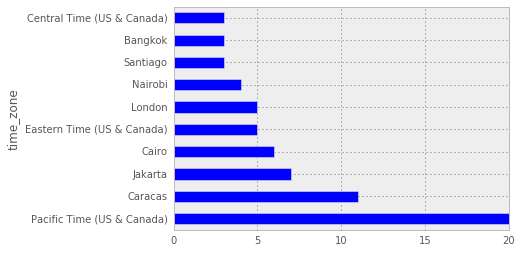

In [16]:
%pylab inline
#plt.rcParams['figure.fixzise'] = (10,10)
projects_by_country_pd['total_time_zone'][:10].plot(kind='barh', rot=0, )